<a href="https://colab.research.google.com/github/HenryLau08/adsai-mlops-2025/blob/main/MLOPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [2]:
%pip install kaggle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:

# imports
import os
import cv2
from roboflow import Roboflow
import shutil
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns


robo_api_key = "sGinQr2B54FkDko52rnT" # Set your roboflow api key
data_dir = "/content/drive/MyDrive/Colab Notebooks/data"
os.makedirs(data_dir, exist_ok=True)
os.makedirs("/root/.config/kaggle/", exist_ok=True)

# shutil.move("kaggle.json", "/root/.config/kaggle/") # manually upload your kaggle.json file and run it once
!chmod 600 /root/.config/kaggle/kaggle.json
import kaggle


Groepsnaam

Groepsleden

michal
quincy
henry
moh
jayden

Opdrachtgever

Tesla


# 1. INLEIDING

opdrachtbeschrijving


Beschrijf het doel van de datapijplijn en geef een korte samenvatting van de stappen die je gaat volgen.


# 2. Data Ingestion
Beschrijf hoe de data wordt ingeladen vanuit verschillende bronnen (Kaggle, Google Images, live camera feeds).


Kaggle Datasets

Beschrijf hoe je de datasets van Kaggle downloadt en inlaadt.

Gebruik bijvoorbeeld de Kaggle API om de datasets te downloaden.

Google Images

Beschrijf hoe je afbeeldingen van Google Images haalt via web scraping of een API.

Leg uit hoe je de afbeeldingen opslaat en organiseert.

Live Camera Feeds

Beschrijf hoe je live videofeeds verwerkt voor realtime voertuigdetectie.

Leg uit hoe je frames uit de videofeeds haalt en deze gebruikt als input voor het model.



## 2.1 Kaggle Datasets

In [ ]:
kaggle_path = str(data_dir + '/kaggle')
os.makedirs(kaggle_path, exist_ok=True)

kaggle.api.dataset_download_files("sakshamjn/vehicle-detection-8-classes-object-detection", path=kaggle_path, unzip=True)

Dataset URL: https://www.kaggle.com/datasets/sakshamjn/vehicle-detection-8-classes-object-detection


In [14]:
images_path = "/content/drive/MyDrive/Colab Notebooks/data/kaggle/train/images"
labels_path = "/content/drive/MyDrive/Colab Notebooks/data/kaggle/train/labels"

images = [f for f in os.listdir(images_path) if f.endswith('.jpg')]
labels = [f.replace('.jpg', '.txt') for f in images]

In [15]:
def extract_labels_and_bboxes(label_file):
    labels_and_bboxes = []
    with open(label_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            # Split by space to get label and bbox
            parts = line.strip().split(' ')
            label = int(parts[0])  # label is the first part
            bbox = [float(x) for x in parts[1:]]  # bbox is the rest (x_center, y_center, width, height)
            labels_and_bboxes.append((label, bbox))
    return labels_and_bboxes

# Create an empty list to store all the extracted data
data = []

# Loop through each image and corresponding label file
for img, lbl in zip(images, labels):
    img_path = os.path.join(images_path, img)
    lbl_path = os.path.join(labels_path, lbl)

    # Extract the labels and bounding boxes from the label file
    labels_and_bboxes = extract_labels_and_bboxes(lbl_path)

    for label, bbox in labels_and_bboxes:
        # Add the data for each label and bounding box into the list
        data.append({
            'image_path': img_path,
            'label_path': lbl_path,
            'label': label,
            'x_center': bbox[0],
            'y_center': bbox[1],
            'width': bbox[2],
            'height': bbox[3]
        })

# Create DataFrame from the list of dictionaries
df_kaggle = pd.DataFrame(data)
csv_path = os.path.join(data_dir, 'kaggle_data.csv')
df_kaggle.to_csv(csv_path, index=False)

In [16]:
display(df_kaggle.head(10))

,image_path,label_path,label,x_center,y_center,width,height
0,/content/drive/MyDrive/Colab Notebooks/data/ka...,/content/drive/MyDrive/Colab Notebooks/data/ka...,2,0.521635,0.295673,0.043269,0.086538
1,/content/drive/MyDrive/Colab Notebooks/data/ka...,/content/drive/MyDrive/Colab Notebooks/data/ka...,2,0.570913,0.604567,0.098558,0.242788
2,/content/drive/MyDrive/Colab Notebooks/data/ka...,/content/drive/MyDrive/Colab Notebooks/data/ka...,7,0.395433,0.537260,0.156250,0.382212
3,/content/drive/MyDrive/Colab Notebooks/data/ka...,/content/drive/MyDrive/Colab Notebooks/data/ka...,4,0.930288,0.747596,0.052885,0.158654
4,/content/drive/MyDrive/Colab Notebooks/data/ka...,/content/drive/MyDrive/Colab Notebooks/data/ka...,4,0.618990,0.290865,0.021635,0.057692
5,/content/drive/MyDrive/Colab Notebooks/data/ka...,/content/drive/MyDrive/Colab Notebooks/data/ka...,7,0.459135,0.212740,0.067308,0.185096
6,/content/drive/MyDrive/Colab Notebooks/data/ka...,/content/drive/MyDrive/Colab Notebooks/data/ka...,4,0.102163,0.419471,0.103365,0.122596
7,/content/drive/MyDrive/Colab Notebooks/data/ka...,/content/drive/MyDrive/Colab Notebooks/data/ka...,2,0.497596,0.675481,0.096154,0.259615
8,/content/drive/MyDrive/Colab Notebooks/data/ka...,/content/drive/MyDrive/Colab Notebooks/data/ka...,7,0.490385,0.403846,0.052885,0.168269
9,/content/drive/MyDrive/Colab Notebooks/data/ka...,/content/drive/MyDrive/Colab Notebooks/data/ka...,7,0.721154,0.784856,0.250000,0.396635


## 2.2 Google Images


## 2.3 Live Camera Feeds


## 2.4 RoboFlow Datasets

In [ ]:
rf = Roboflow(api_key=robo_api_key)

In [ ]:
project = rf.workspace("lynkeus-01").project("vehicle-detection-iusts")
version = project.version(2)
dataset = version.download("tfrecord")
dataset_location = dataset.location
shutil.move(dataset_location, data_dir)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to vehicle-detection-2 in tfrecord:: 100%|██████████| 11/11 [00:01<00:00,  6.36it/s]


'/content/drive/MyDrive/Colab Notebooks/data/vehicle-detection-2'

In [ ]:
project = rf.workspace("pedroluis897-gmail-com").project("vehicles-erclb")
version = project.version(5)
dataset = version.download("tfrecord")
dataset_location = dataset.location
shutil.move(dataset_location, data_dir)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to VEHICLES-5 in tfrecord:: 100%|██████████| 8/8 [00:01<00:00,  7.61it/s]


'/content/drive/MyDrive/Colab Notebooks/data/VEHICLES-5'

In [38]:
# rf1_folder = "/content/drive/MyDrive/Colab Notebooks/data/vehicle-detection-2/train"
# print(os.listdir(rf1_folder))

['vehicles.tfrecord', 'vehicles_label_map.pbtxt']


In [39]:
# train_tfrecord = os.path.join(rf1_folder, 'vehicles.tfrecord')

In [40]:
# raw_dataset = tf.data.TFRecordDataset(train_tfrecord)


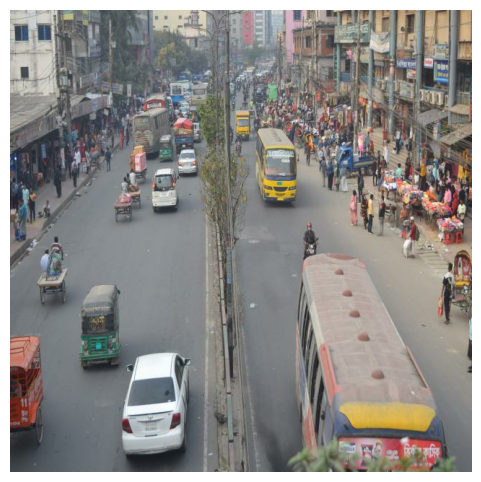

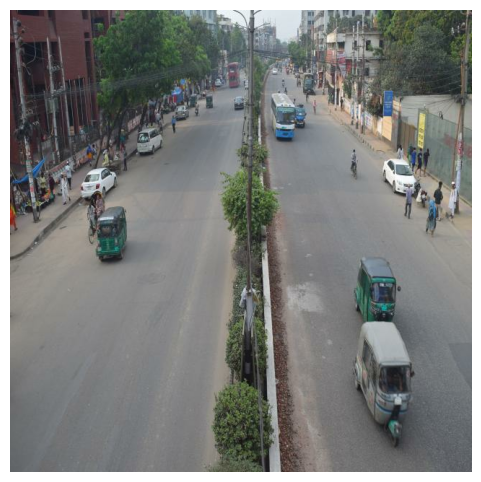

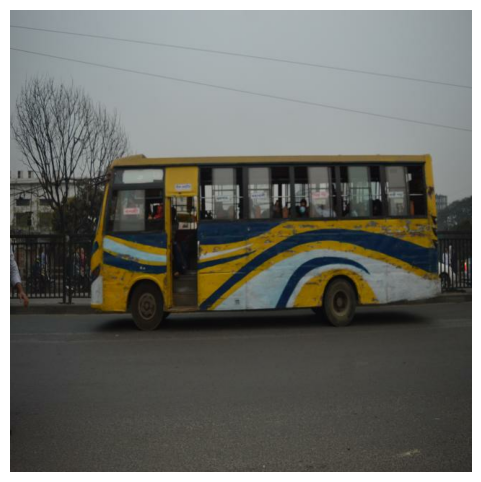

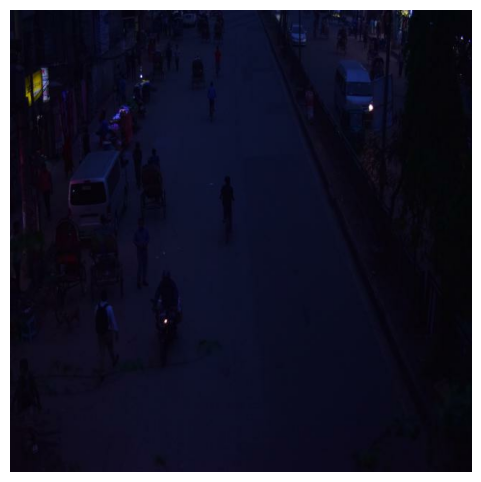

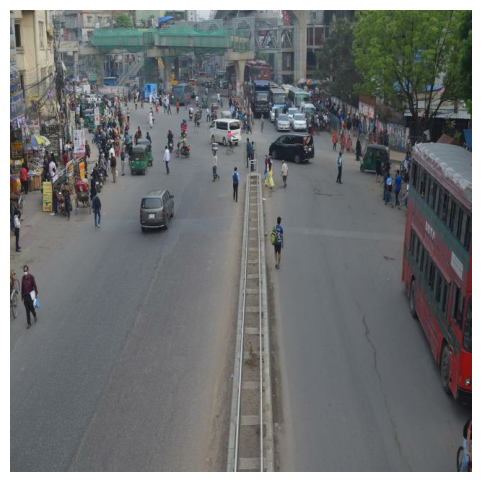

In [41]:
# def parse_tfrecord_fn(example):
#     feature_description = {
#         "image/encoded": tf.io.FixedLenFeature([], tf.string),  # Image data
#     }
#     example = tf.io.parse_single_example(example, feature_description)
#     image = tf.image.decode_jpeg(example["image/encoded"], channels=3)
#     return image

# # Extract and display the first 5 images
# for raw_record in raw_dataset.take(5):
#     image = parse_tfrecord_fn(raw_record)
#     plt.figure(figsize=(6, 6))
#     plt.imshow(image.numpy())
#     plt.axis("off")
#     plt.show()

In [ ]:
# tfrecord_file = "/content/drive/MyDrive/Colab Notebooks/data/VEHICLES-5/train/vehicles.tfrecord"
# output_image_dir = "/content/extracted_images"  # Change this to where you want to store images
# output_label_dir = "/content/extracted_labels"  # For YOLO labels

# # Create output directories if they don't exist
# os.makedirs(output_image_dir, exist_ok=True)
# os.makedirs(output_label_dir, exist_ok=True)

# # Define TFRecord feature structure
# feature_description = {
#     "image/encoded": tf.io.FixedLenFeature([], tf.string),
#     "image/filename": tf.io.FixedLenFeature([], tf.string),  # File name
#     "image/object/class/text": tf.io.VarLenFeature(tf.string),  # Class labels
#     "image/object/bbox/xmin": tf.io.VarLenFeature(tf.float32),
#     "image/object/bbox/ymin": tf.io.VarLenFeature(tf.float32),
#     "image/object/bbox/xmax": tf.io.VarLenFeature(tf.float32),
#     "image/object/bbox/ymax": tf.io.VarLenFeature(tf.float32),
# }

# # Read TFRecord file
# raw_dataset = tf.data.TFRecordDataset(tfrecord_file)

# # Data storage
# data = []

# # Function to parse each TFRecord entry
# def parse_tfrecord_fn(example):
#     example = tf.io.parse_single_example(example, feature_description)

#     # Decode image
#     image = tf.image.decode_jpeg(example["image/encoded"], channels=3)
#     filename = example["image/filename"].numpy().decode("utf-8")

#     # Bounding box coordinates
#     xmin = example["image/object/bbox/xmin"].values.numpy()
#     ymin = example["image/object/bbox/ymin"].values.numpy()
#     xmax = example["image/object/bbox/xmax"].values.numpy()
#     ymax = example["image/object/bbox/ymax"].values.numpy()

#     # Class labels
#     labels = [label.decode("utf-8") for label in example["image/object/class/text"].values.numpy()]

#     return filename, image.numpy(), labels, xmin, ymin, xmax, ymax

# # Process each image in the dataset
# for raw_record in tqdm(raw_dataset, desc="Processing TFRecord"):
#     filename, image, labels, xmin, ymin, xmax, ymax = parse_tfrecord_fn(raw_record)

#     # Save image
#     image_path = os.path.join(output_image_dir, filename)
#     cv2.imwrite(image_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

#     # Save label file (YOLO format)
#     label_path = os.path.join(output_label_dir, filename.replace(".jpg", ".txt"))

#     with open(label_path, "w") as f:
#         for i in range(len(labels)):
#             # YOLO format requires normalized center_x, center_y, width, height
#             x_center = (xmin[i] + xmax[i]) / 2
#             y_center = (ymin[i] + ymax[i]) / 2
#             width = xmax[i] - xmin[i]
#             height = ymax[i] - ymin[i]

#             # YOLO format: class_id center_x center_y width height
#             f.write(f"{labels[i]} {x_center} {y_center} {width} {height}\n")

#     # Store metadata in a dataframe
#     for i in range(len(labels)):
#         data.append([filename, image_path, labels[i], xmin[i], ymin[i], xmax[i], ymax[i]])

# # Create DataFrame
# df = pd.DataFrame(data, columns=["filename", "image_path", "class", "xmin", "ymin", "xmax", "ymax"])

# # Save as CSV (optional)
# df.to_csv("/content/dataset_metadata.csv", index=False)

# # Show first few rows
# print(df.head())

In [ ]:
# display(df.head(10))

In [ ]:
# set(df['class'])

In [ ]:
# %pip install tf-slim
# %pip install tensorflow-object-detection-api

In [ ]:
# !pip install protobuf==3.20.3

In [2]:
# from object_detection.protos import string_int_label_map_pb2
# from google.protobuf import text_format

In [3]:
# label_map_path = "/content/drive/MyDrive/Colab Notebooks/data/vehicle-detection-2/train/vehicles_label_map.pbtxt"

In [ ]:
# def load_label_map(label_map_path):
#     label_map = {}

#     # Load and parse the pbtxt file
#     with open(label_map_path, "r") as f:
#         proto_str = f.read()

#     # Parse the label map using TensorFlow
#     item_list = tf.train.Example().FromString(proto_str)

#     for item in item_list.item:
#         class_id = item.id
#         class_name = item.display_name
#         label_map[class_id] = class_name

#     return label_map

# # Load label map
# label_map = load_label_map(label_map_path)

# # Print out the label map (class_id -> class_name)
# print(label_map)

In [ ]:
# def load_label_map(label_map_path):
#     label_map = {}

#     # Load and parse the pbtxt file
#     with open(label_map_path, "rb") as f: # Changed to 'rb' to read in binary mode
#         proto_str = f.read()

#     # Parse the label map using TensorFlow
#     item_list = tf.train.Example().FromString(proto_str) # Now proto_str is bytes

#     for item in item_list.feature: # Corrected from item_list.item to item_list.feature
#         if item.name == 'item':
#             for sub_item in item.bytes_list.value:
#                 # Decode sub_item as a TF Example
#                 sub_example = tf.train.Example()
#                 sub_example.ParseFromString(sub_item)
#                 # Extract class_id and class_name
#                 class_id = int(sub_example.features.feature['id'].int64_list.value[0])
#                 class_name = sub_example.features.feature['name'].bytes_list.value[0].decode('utf-8')
#                 # Add to label_map
#                 label_map[class_id] = class_name

#     return label_map

# # Load label map
# label_map = load_label_map(label_map_path)

# # Print out the label map (class_id -> class_name)
# print(label_map)

# 3. Data Opschonen en Transformeren

Beschrijf de stappen voor data cleaning, data augmentation en data transformation.

In deze sectie beschrijf je de stappen voor het opschonen en transformeren van de data. Gebruik markdown-cellen om elke stap te beschrijven en code-cellen om de transformaties uit te voeren.

Data Cleaning

Beschrijf hoe je de afbeeldingen opschoont (bijvoorbeeld door ze allemaal naar hetzelfde formaat te converteren).

Voer kleurnormalisatie uit en pas cropping en padding toe waar nodig.

Data Augmentation

Beschrijf hoe je data augmentation toepast om de dataset te vergroten en het model robuuster te maken.

Gebruik technieken zoals rotatie, spiegeling, schalen, translatie, shearing en cropping.

Data Transformation

Beschrijf hoe je de afbeeldingen transformeert om ze geschikt te maken voor machine learning (bijvoorbeeld normalisatie en kleurtransformaties).

## 3.1 Data Cleaning

## 3.2 Data Augmentation

## 3.3 Data Transformation

# 4. Machine Learning Pipeline

Beschrijf hoe het objectdetectiemodel wordt getraind en geëvalueerd.


In deze sectie beschrijf je hoe je het objectdetectiemodel traint en evalueert. Gebruik markdown-cellen om elke stap te beschrijven en code-cellen om het model te trainen en te evalueren.

Objectdetectie Model

Beschrijf hoe je een objectdetectiemodel (bijvoorbeeld YOLO, Faster R-CNN of EfficientDet) traint op de dataset.

Leg uit hoe je het model evalueert met behulp van metrieken zoals precisie, recall en F1-score.

Image Captioning

Beschrijf eventueel hoe je een image captioning-model toevoegt om beschrijvingen van gedetecteerde voertuigen te genereren.



## 4.1 Train-Test Split

## 4.2 Model Bouwen

## 4.3 Model Trainen

## 4.4 Model Evalueren

# 5. Deployment

Beschrijf hoe het model wordt gedeployed op edge-apparaten en in de cloud.

In deze sectie beschrijf je hoe je het model deployt op edge-apparaten en in de cloud. Gebruik markdown-cellen om de deploymentstrategie te beschrijven.

Edge Deployment

Beschrijf hoe je het model implementeert op edge-apparaten zoals slimme camera's of embedded systemen.

Leg uit hoe je ervoor zorgt dat het model realtime voertuigdetectie kan uitvoeren.

Cloud Deployment

Beschrijf hoe je het geavanceerde deep learning-model in de cloud deployt voor voertuigclassificatie.



## 5.1 Edge Deployment

## 5.2 Cloud Deployment

# 6. Monitoring en Feedback

Beschrijf hoe de prestaties van het model worden gemonitord en hoe het model wordt hertraind op basis van nieuwe data.

In deze sectie beschrijf je hoe je de prestaties van het model monitort en hoe je het model hertraind op basis van nieuwe data. Gebruik markdown-cellen om de monitoringstrategie te beschrijven.

Data Drift Detection

Beschrijf hoe je veranderingen in de inkomende data detecteert en hoe je hierop reageert.

Model Performance Monitoring

Beschrijf hoe je de nauwkeurigheid, recall en precision van het model continu monitort.

Leg uit hoe je automatisch logging van verkeerde voorspellingen implementeert.

Hertraining

Beschrijf hoe je het model periodiek hertraind op basis van nieuwe data en feedback.

7. Conclusie


## 6.1 Data Drift Detection

## 6.2 Hertraining

# 7. Conclusie

Geef een samenvatting van de datapijplijn en bespreek eventuele uitdagingen of verbeterpunten.

In deze sectie geef je een samenvatting van de datapijplijn en bespreek je eventuele uitdagingen of verbeterpunten. Gebruik markdown-cellen om de conclusie te schrijven.




# 8. Bronvermelding